# Make plots of `bhm` and `bhm_e`

For the paper!

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import imageio
import pandas as pd
import seaborn as sns
sns.set(style='ticks')

C:\Users\pfsch\Anaconda3\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
sys.path.append('../../scripts')

In [3]:
import bicorr as bicorr
import bicorr_e as bicorr_e
import bicorr_plot as bicorr_plot
import bicorr_sums as bicorr_sums
import bicorr_math as bicorr_math

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
os.getcwd()

'C:\\Users\\pfsch\\Box Sync\\Projects\\fnpc\\analysis\\Cf072115_to_Cf072215b'

# Load data

In [6]:
det_df = bicorr.load_det_df('../../meas_info/det_df_pairs_angles.csv')
det_df.head()

,d1,d2,d1d2,angle
0,1,2,102,15.0
1,1,3,103,30.0
2,1,4,104,45.0
3,1,5,105,60.0
4,1,6,106,75.0


In [7]:
num_fissions = int(int(sio.loadmat('datap/num_fissions.mat')['num_fissions'])*float(sio.loadmat('datap/fc_efficiency.mat')['fc_efficiency']))
print(num_fissions)

1422133977


# Time space

In [36]:
npzfile = np.load('datap/bhp_nn_by_pair_1ns.npz')
pair_is = npzfile['pair_is']
bhp_nn_pos = npzfile['bhp_nn_pos']
bhp_nn_neg = npzfile['bhp_nn_neg']
dt_bin_edges = npzfile['dt_bin_edges']

In [37]:
bhp_nn_diff = np.subtract(bhp_nn_pos.astype(np.int32),bhp_nn_neg[:,::-1,::-1].astype(np.int32))

## Background estimates

Run some calculations to estimate relative magnitude of background. 

In [10]:
bhp_nn_diff.shape

(861, 200, 200)

In [11]:
a = bhp_nn_neg
b = bhp_nn_pos
print(a.shape, b.shape)

fraction_negative = np.divide(a,b,out=np.zeros_like(a), where=b!=0)
fraction_negative.shape

(861, 200, 200) (861, 200, 200)


(861, 200, 200)

Overall number of events

In [12]:
a = np.sum(bhp_nn_neg)
b = np.sum(bhp_nn_pos)
print(a, b)

fraction_negative = np.divide(a,b,out=np.zeros_like(a), where=b!=0)
fraction_negative

209861.0 8300712.0


array(0.02528229)

In relevant time ranges:

In [13]:
bicorr_math.convert_energy_to_time(0.62)

97.14588258389688

In [14]:
bicorr_math.convert_energy_to_time(6)

31.228032150250982

In [15]:
i_min = int(np.digitize(30,dt_bin_edges))
i_max = int(np.digitize(100,dt_bin_edges))
print(i_min,i_max)

31 101


In [16]:
a = np.sum(bhp_nn_neg[i_min:i_max,:,:])
b = np.sum(bhp_nn_pos[i_min:i_max,:,:])
print(a, b)

fraction_negative = np.divide(a,b,out=np.zeros_like(a), where=b!=0)
fraction_negative

16362.0 667054.0


array(0.02452875)

Alright we'll go with this.

## Make plot of all angles

In [17]:
norm_factor = num_fissions * len(pair_is) * np.power((dt_bin_edges[1]-dt_bin_edges[0]),2)
bhp = np.sum(bhp_nn_diff,axis=0)/norm_factor

In [18]:
vmin = np.min(bhp[np.nonzero(bhp)])
vmax = np.max(bhp)
print(vmin,vmax)

-1.551707777724951e-11 4.909930084043371e-09


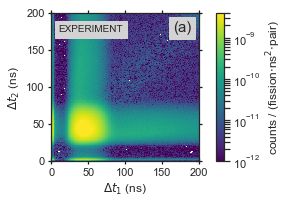

In [20]:
ax = bicorr_plot.bhp_plot(bhp,dt_bin_edges,show_flag=False,
                     vmin = 1e-12, vmax=4e-9, clear=False)
ax.text(10,175,'EXPERIMENT', size=10, backgroundcolor='lightgray')
ax.text(165,175,'(a)',size=15,backgroundcolor='lightgray')
bicorr_plot.save_fig_to_folder('bhm_all_normed',dpi=150)
plt.show()

## Pairs at 15 degrees

In [42]:
all_pairs = pair_is
all_pairs.shape

(861,)

In [27]:
with_to_without = dict(zip(all_pairs,np.arange(861)))

In [28]:
pair_is = bicorr.generate_pair_is(det_df, th_min=10, th_max=20, ignore_fc_neighbors_flag=True)
pair_is_without = [with_to_without[pair_is[i]] for i in range(len(pair_is))]

In [29]:
norm_factor = num_fissions * len(pair_is) * np.power((dt_bin_edges[1]-dt_bin_edges[0]),2)
bhp = np.sum(bhp_nn_diff[pair_is_without,:,:],axis=0)/norm_factor

<Figure size 432x288 with 0 Axes>

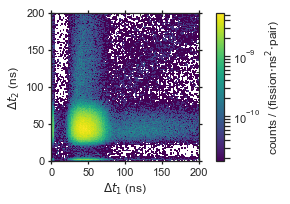

In [30]:
bicorr_plot.bhp_plot(bhp,dt_bin_edges,show_flag=True,
                     save_flag=True,
                     save_filename = 'bhm_15_normed')

## Pairs at 35 degrees

In [26]:
pair_is = bicorr.generate_pair_is(det_df, th_min=40, th_max=50, ignore_fc_neighbors_flag=True)
pair_is_without = [with_to_without[pair_is[i]] for i in range(len(pair_is))]

In [27]:
norm_factor = num_fissions * len(pair_is) * np.power((dt_bin_edges[1]-dt_bin_edges[0]),2)
bhp = np.sum(bhp_nn_diff[pair_is_without,:,:],axis=0)/norm_factor

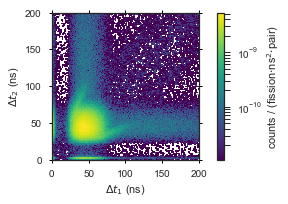

<Figure size 576x396 with 0 Axes>

In [28]:
bicorr_plot.bhp_plot(bhp,dt_bin_edges,show_flag=True,
                     save_flag=True,
                     save_filename = 'bhm_45_normed')

# Energy space

## All pairs

In [43]:
bhm_e, e_bin_edges, note = bicorr_e.load_bhm_e('datap')

In [44]:
bhp_e, norm_factor = bicorr_e.build_bhp_e(bhm_e,e_bin_edges,pair_is=all_pairs,num_fissions=num_fissions)

In [45]:
vmin = np.min(bhp_e[np.nonzero(bhp_e)])
vmax = np.max(bhp_e)
print(vmin, vmax)

1.3067012865052215e-09 3.132947004524919e-05


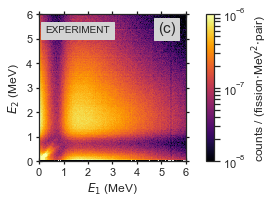

In [46]:
ax = bicorr_plot.bhp_e_plot(bhp_e, e_bin_edges, show_flag = False, 
                       vmin = 1e-8, vmax=1e-6, zoom_range =[0,6],
                       clear_flag=False)
ax.text(0.25,5.25,'EXPERIMENT', size=10, backgroundcolor='lightgray') 
ax.text(4.85,5.25,'(c)',size=15,backgroundcolor='lightgray')
bicorr_plot.save_fig_to_folder(fig_filename='bhm_e_all')
plt.show()

In [33]:
bhm_e.shape

(990, 1, 600, 600)

## Pairs at 15 degrees

In [34]:
pair_is = bicorr.generate_pair_is(det_df, th_min=10, th_max=20, ignore_fc_neighbors_flag=True)

In [35]:
bhp_e, norm_factor = bicorr_e.build_bhp_e(bhm_e,e_bin_edges,pair_is=pair_is,num_fissions=num_fissions)

In [36]:
vmin = np.min(bhp_e[np.nonzero(bhp_e)])
vmax = np.max(bhp_e)
print(vmin, vmax)

2.8126745192024896e-08 8.519591118664342e-05


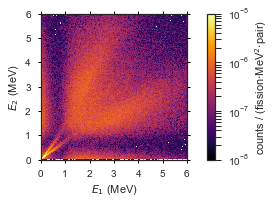

<Figure size 576x396 with 0 Axes>

In [37]:
bicorr_plot.bhp_e_plot(bhp_e, e_bin_edges, show_flag = True, 
                       vmin = 1e-8, vmax=1e-5, zoom_range =[0,6],
                       save_flag = True, save_filename = 'bhm_e_15')

## Pairs at 45 degrees

In [32]:
pair_is = bicorr.generate_pair_is(det_df, th_min=40, th_max=50, ignore_fc_neighbors_flag=True)

In [33]:
bhp_e, norm_factor = bicorr_e.build_bhp_e(bhm_e,e_bin_edges,pair_is=pair_is,num_fissions=num_fissions)

In [34]:
vmin = np.min(bhp_e[np.nonzero(bhp_e)])
vmax = np.max(bhp_e)
print(vmin, vmax)

1.121608053953385e-08 4.023208089530792e-05


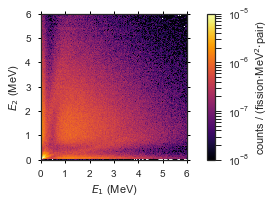

<Figure size 576x396 with 0 Axes>

In [35]:
bicorr_plot.bhp_e_plot(bhp_e, e_bin_edges, show_flag = True, 
                       vmin = 1e-8, vmax=1e-5, zoom_range =[0,6],
                       save_flag = True, save_filename = 'bhm_e_45')